In [1]:
import sys
from copy import copy, deepcopy
import sympy as sp
import itertools
import math

from sympy.physics.vector import Point, ReferenceFrame
from sympy.physics.vector import Vector, outer, dynamicsymbols
from sympy.physics.vector import kinematic_equations, vprint
from sympy.physics.vector.functions import time_derivative
from sympy.physics.mechanics import LagrangesMethod, RigidBody, Lagrangian, msubs
from sympy.physics.mechanics.linearize import Linearizer

from sympy.utilities.codegen import codegen
from sympy.printing.cxxcode import cxxcode
from sympy.printing.pycode import pycode, PythonCodePrinter, NumPyPrinter

from IPython.display import display, Latex

sp.init_printing(use_latex='mathjax')

import casadi as cs
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

print("Loaded python modules.")

Loaded python modules.


In [2]:
a, b, c, d, e, f, g, h = sp.symbols("a,b,c,d,e,f,g,h")
p = [a, b, c, d, e, f, g, h]
x_0, x_f = sp.symbols("X_0,x_f")
t = sp.symbols("t")

In [40]:
rate = 50
z_0 = sum([t**i * p_i for i, p_i in enumerate(p)])
z_1 = sp.diff(z_0, t)
z_2 = sp.diff(z_1, t)
z_3 = sp.diff(z_2, t)

print("z")
display(z_0)
print("z'")
display(z_1)
print("z''")
display(z_2)
print("z'''")
display(z_3)

def get_ti(t_end):
    n = rate * t_end
    return np.linspace(0, t_end, n)


def get_datamatrix(t_end):
    z_i = sp.Matrix([
        z_0.subs(t, 0),
        z_1.subs(t, 0),
        z_2.subs(t, 0),
        z_3.subs(t, 0),
        z_0.subs(t, t_end),
        z_1.subs(t, t_end),
        z_2.subs(t, t_end),
        z_3.subs(t, t_end),
    ])
    datamatrix = z_i.jacobian(p)
    return datamatrix


vel_dock = 0.01
    

def get_constraint_vectors(x_0, x_end, y_0, y_end, theta_0, theta_end):
    constraintvector_theta = sp.Matrix([theta_0, 0, 0, 0, theta_end, 0, 0, 0])
    vel_x_end = vel_dock * math.cos(-theta_end)
    vel_y_end = vel_dock * math.sin(-theta_end)
    constraintvector_x = sp.Matrix([x_0, 0, 0, 0, x_end, vel_x_end, 0, 0])
    constraintvector_y = sp.Matrix([y_0, 0, 0, 0, y_end, vel_y_end, 0, 0])
    return constraintvector_x, constraintvector_y, constraintvector_theta


def get_feedforward_position(constraintvector, t_end):
    params = get_datamatrix(t_end).inv()@constraintvector
    z_sol = z_0
    for i, p_i in enumerate(p):
        z_sol = z_sol.subs(p_i, params[i])
    n = t_end * rate
    t_i = np.linspace(0, t_end, n)
    x_i = np.array([(z_sol.subs(t, t_current)).evalf() for t_current in t_i])
    return x_i


def get_feedforward_velocity(constraintvector, t_end):
    params = get_datamatrix(t_end).inv()@constraintvector
    z_sol = z_1
    for i, p_i in enumerate(p):
        z_sol = z_sol.subs(p_i, params[i])
    n = t_end * rate
    t_i = np.linspace(0, t_end, n)
    x_i = np.array([(z_sol.subs(t, t_current)).evalf() for t_current in t_i])
    return x_i


def get_feedforward_acceleration(constraintvector, t_end):
    params = get_datamatrix(t_end).inv()@constraintvector
    z_sol = z_2
    for i, p_i in enumerate(p):
        z_sol = z_sol.subs(p_i, params[i])
    n = t_end * rate
    t_i = np.linspace(0, t_end, n)
    x_i = np.array([(z_sol.subs(t, t_current)).evalf() for t_current in t_i])
    return x_i


m = 7.5 + 0.296
J = 0.099 + 1.17e-4


def get_feedforward_input(constraintvector_x, constraintvector_y, constraintvector_theta, t_end):
    
    n = t_end * rate
    t_i = np.linspace(0, t_end, n)
    
    theta_i = get_feedforward_position(constraintvector_theta, t_end)
    x_i_2 = get_feedforward_acceleration(constraintvector_x, t_end)
    y_i_2 = get_feedforward_acceleration(constraintvector_y, t_end)
    theta_i_2 = get_feedforward_acceleration(constraintvector_theta, t_end)
    
    f_x = [m * (math.cos(theta_i[i])*x_i_2[i] + math.sin(theta_i[i])*y_i_2[i]) for i in range(n)]
    f_y = [m * (-math.sin(theta_i[i])*x_i_2[i] + math.cos(theta_i[i])*y_i_2[i]) for i in range(n)]
    torque = [J * theta_i_2[i] for i in range(n)]
    
    f_x = np.array(f_x)
    f_y = np.array(f_y)
    torque = np.array(torque)
    
    return f_x, f_y, torque
    

def get_feed_forward(x_0, x_end, y_0, y_end, theta_0, theta_end, t_end):
    
    constraintvector_x, constraintvector_y, constraintvector_theta = \
    get_constraint_vectors(x_0, x_end, y_0, y_end, theta_0, theta_end)
    
    ff_x_0 = get_feedforward_position(constraintvector_x, t_end)
    ff_y_0 = get_feedforward_position(constraintvector_y, t_end)
    ff_theta_0 = get_feedforward_position(constraintvector_theta, t_end)
    
    ff_x_1 = get_feedforward_velocity(constraintvector_x, t_end)
    ff_y_1 = get_feedforward_velocity(constraintvector_y, t_end)
    ff_theta_1 = get_feedforward_velocity(constraintvector_theta, t_end)
    
    ff_x_2 = get_feedforward_acceleration(constraintvector_x, t_end)
    ff_y_2 = get_feedforward_acceleration(constraintvector_y, t_end)
    ff_theta_2 = get_feedforward_acceleration(constraintvector_theta, t_end)
    
    f_x, f_y, torque = get_feedforward_input(constraintvector_x, constraintvector_y, constraintvector_theta, t_end)
    
    data = {
        "pos_x": ff_x_0,
        "pos_y": ff_y_0,
        "pos_theta": ff_theta_0,
        "vel_x": ff_x_1,
        "vel_y": ff_y_1,
        "vel_theta": ff_theta_1,
        "acc_x": ff_x_2,
        "acc_y": ff_y_2,
        "acc_theta": ff_theta_2,
        "f_x": f_x,
        "f_y": f_y,
        "torque": torque,
        "t_i": np.linspace(0, t_end, t_end * rate),
    }
    
    return data


def plot_feedforward_data(data):
    
    plt.figure()
    plt.plot(data["pos_x"], data["pos_y"])
    
    plt.figure()
    plt.plot(data["t_i"], data["vel_x"])
    plt.figure()
    plt.plot(data["t_i"], data["vel_y"])
    plt.figure()
    plt.plot(data["t_i"], data["vel_theta"])
    
    plt.figure()
    plt.plot(data["t_i"], data["f_x"])
    plt.figure()
    plt.plot(data["t_i"], data["f_y"])
    plt.figure()
    plt.plot(data["t_i"], data["torque"])

z


             2      3      4      5      6      7
a + b⋅t + c⋅t  + d⋅t  + e⋅t  + f⋅t  + g⋅t  + h⋅t 

z'


                 2        3        4        5        6
b + 2⋅c⋅t + 3⋅d⋅t  + 4⋅e⋅t  + 5⋅f⋅t  + 6⋅g⋅t  + 7⋅h⋅t 

z''


                    2         3         4         5
2⋅c + 6⋅d⋅t + 12⋅e⋅t  + 20⋅f⋅t  + 30⋅g⋅t  + 42⋅h⋅t 

z'''


                     2          3          4
6⋅d + 24⋅e⋅t + 60⋅f⋅t  + 120⋅g⋅t  + 210⋅h⋅t 

In [41]:
x_0 = -1.40
y_0 = -0.50
theta_0 = np.pi / 2
x_end = 0
y_end = 0.50
theta_end = 0
t_end = 10

In [42]:
data = get_feed_forward(x_0, x_end, y_0, y_end, theta_0, theta_end, t_end)

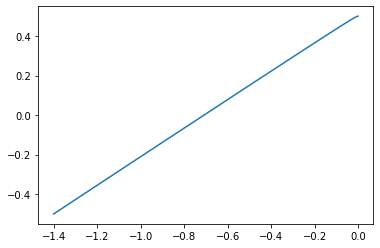

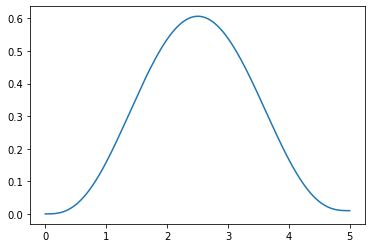

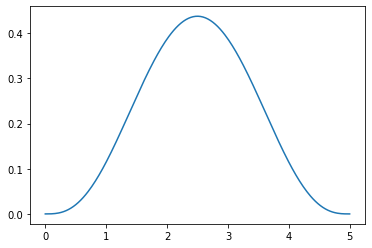

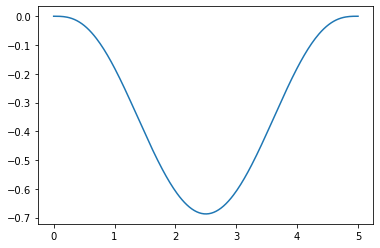

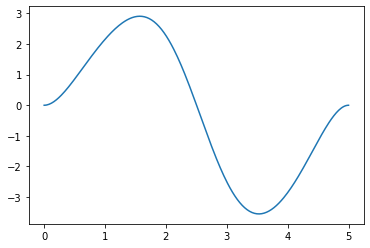

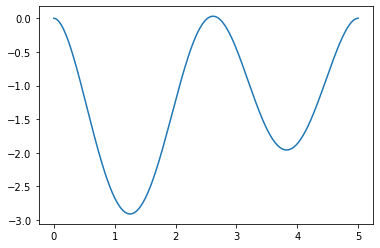

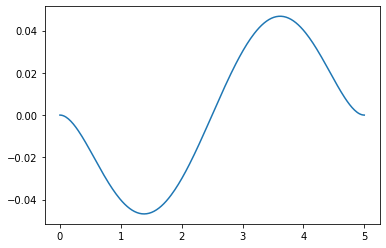

In [43]:
plot_feedforward_data(data)